In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0
    !pip -q install minari
    !pip -q install gymnasium-robotics
    !pip -q install torchrl

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from gymnasium import spaces
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import minari
from minari import DataCollector

import matplotlib.pyplot as plt


torch.manual_seed(42)

[Minari](https://minari.farama.org/main/) is a Python API that hosts a collection of popular Offline Reinforcement Learning datasets. The environments from which these datasets are generated follow the [Gymnasium API](https://gymnasium.farama.org/). The datasets are publicly available in a [Farama GCP bucket](https://console.cloud.google.com/storage/browser/minari-datasets;tab=objects?forceOnBucketsSortingFiltering=false&amp;project=mcmes-345620&amp;prefix=&amp;forceOnObjectsSortingFiltering=false) and can be downloaded through the Minari CLI. Minari also provides dataset handling features such as episode sampling, filtering trajectories, as well as dataset generation utilities.

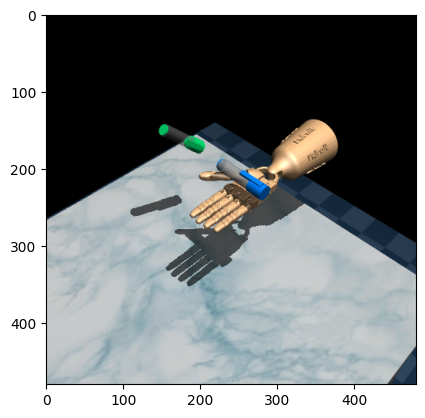

In [3]:
dataset = minari.load_dataset('D4RL/pen/expert-v2', download=True)
env = dataset.recover_environment(render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [4]:
observation_space = env.observation_space
action_space = env.action_space
print(f"observation_space: {observation_space}")
print(f"action_space: {action_space}")

observation_space: Box(-inf, inf, (45,), float64)
action_space: Box(-1.0, 1.0, (24,), float32)


In [5]:
state_dim = observation_space.shape[0]
action_dim = action_space.shape[0]

[TorchRL](https://pytorch.org/rl/) is an open-source Reinforcement Learning library for PyTorch. TorchRL provides pytorch and python-first, low and high level abstractions for RL that are intended to be efficient, modular, documented and properly tested. The code is aimed at supporting research in RL. Most of it is written in python in a highly modular way, such that researchers can easily swap components, transform them or write new ones with little effort.

In [ ]:
from torchrl.data.datasets.minari_data import MinariExperienceReplay
from torchrl.data.replay_buffers import SamplerWithoutReplacement
from torchrl.envs import DoubleToFloat

dataset_id = "D4RL/pen/expert-v2"
batch_size = 128

replay_buffer = MinariExperienceReplay(
    dataset_id,
    split_trajs=False,
    batch_size=batch_size,
    sampler=SamplerWithoutReplacement(),
    transform=DoubleToFloat(),
)

## Introduction
**Advantage Weighted Actor-Critic (AWAC)** is a novel approach in the domain of offline reinforcement learning that aims to efficiently utilize a fixed dataset of experiences to learn optimal policies. The core idea behind AWAC is to leverage the advantage function to guide the policy improvement step, ensuring that the updated policy favors actions that lead to higher-than-average returns.

## Key Concepts

### Advantage Function
The advantage function, $A(s, a)$, measures the relative benefit of taking an action $a$ in state $s$ over the average action at that state. It is defined as the difference between the Q-value of the action and the value function of the state:

$$
A(s, a) = Q(s, a) - V(s)
$$

### Actor-Critic Architecture
AWAC utilizes the actor-critic architecture, where the "actor" refers to the policy $\pi(a|s)$ that selects actions based on the current state, and the "critic" estimates the value function $V(s)$ or the action-value function $Q(s, a)$. This architecture enables efficient policy improvement and value estimation.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.transforms import TanhTransform
from torch.distributions.normal import Normal
from torch.distributions.transformed_distribution import TransformedDistribution

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.mu_head = nn.Linear(128, action_dim)
        self.log_sigma = nn.Parameter(torch.zeros(action_dim, dtype=torch.float32))

    def forward(self, state):
        features = #<YOUR_CODE>
        mu = #<YOUR_CODE>
        sigma = #<YOUR_CODE>
        return mu, sigma

    def get_distribution(self, state):
        mu, sigma = self.forward(state)
        return TransformedDistribution(Normal(mu, sigma), [TanhTransform(cache_size=1)])

    @torch.no_grad()
    def sample(self, state):
        return self.get_distribution(state).sample()

    @torch.no_grad()
    def get_action(self, state):
        return self.forward(state)[0]



class QCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        return #<YOUR_CODE>

In [12]:
def evaluate(env, actor, n_games=10, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            action = actor.get_action(torch.tensor([s], dtype=torch.float32)).numpy()[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [13]:
from tqdm import trange
from IPython.display import clear_output

plt.rcParams["axes.grid"] = True

## AWAC Algorithm

1. **Initialization**: Start with an initial policy $\pi_0$ and a dataset of experiences $D$ collected under some behavior policy.

2. **Critic Update**: Use the dataset $D$ to update the critic by minimizing the difference between the predicted Q-values and the observed rewards plus the discounted value of the next state. This step can be formulated as minimizing the loss:

$$
L_{critic} = \mathbb{E}_{(s, a, r, s') \sim D}[(Q(s, a) - (r + \gamma V(s')))^2]
$$

3. **Advantage Calculation**: Calculate the advantage $A(s, a) = Q(s, a) - Q(s, a_{new}), a_{new} \sim \pi_\theta(.|s)$ using the updated critic for actions in the dataset.

4. **Actor Update**: Improve the policy by re-weighting the likelihood of actions in proportion to their advantage. This step encourages the selection of actions with higher-than-average returns. The policy is updated by optimizing:

$$
L_{actor} = -\mathbb{E}_{(s, a) \sim D}[\log \pi(a|s) \cdot \exp(\dfrac{A(s, a)}{\lambda})]
$$

where $\lambda$ is a temperature parameter that controls the importance of the advantage in the policy update.

5. **Iterate**: Repeat the critic update and actor update steps until the policy converges or a predetermined number of iterations is reached.

## Incorporating the Twin Trick in AWAC

### Overestimation Bias in Q-Learning
A common challenge in Q-learning and its variants, including those used in actor-critic architectures, is the overestimation of Q-values. This bias occurs because the max operator in the Q-learning update tends to select overoptimistic value estimates, leading to unstable training and suboptimal policies.

### The Twin Trick Solution
To mitigate the overestimation bias, AWAC employs a technique known as the "twin trick." This involves maintaining two separate critic networks, $Q_{\phi_1}(s, a)$ and $Q_{\phi_2}(s, a)$, with their own sets of parameters $\theta_1$ and $\theta_2$. These networks are trained on the same experiences but initialized differently to provide independent estimates of the action-value function.

### Critic Update with the Twin Trick
During the critic update step, both critic networks are updated using the observed transitions. However, when calculating the target value for updating each critic, AWAC uses the minimum of the two Q-value estimates from the twin critics for the next state-action pair:

$$
y = r + \gamma \min_{i=1,2} Q_{\phi^-_i}(s', \pi(s'))
$$

This target $y$ is then used to update both critic networks. By taking the minimum of the two estimates, the twin trick effectively reduces the likelihood of overestimation bias because it is less probable for both networks to overestimate the Q-value of the same action simultaneously.

### Advantages of the Twin Trick in AWAC

- **Reduced Overestimation Bias**: By using the minimum of the Q-value estimates from two critics, AWAC limits the impact of overestimation, leading to more accurate value estimates and more stable learning.
- **Improved Policy Performance**: With more reliable critic estimates, the policy update step can make better-informed adjustments, potentially leading to higher-quality policies.
- **Enhanced Stability**: The twin trick contributes to the overall stability of the AWAC algorithm, making it more robust against the fluctuations that can occur in offline RL settings.

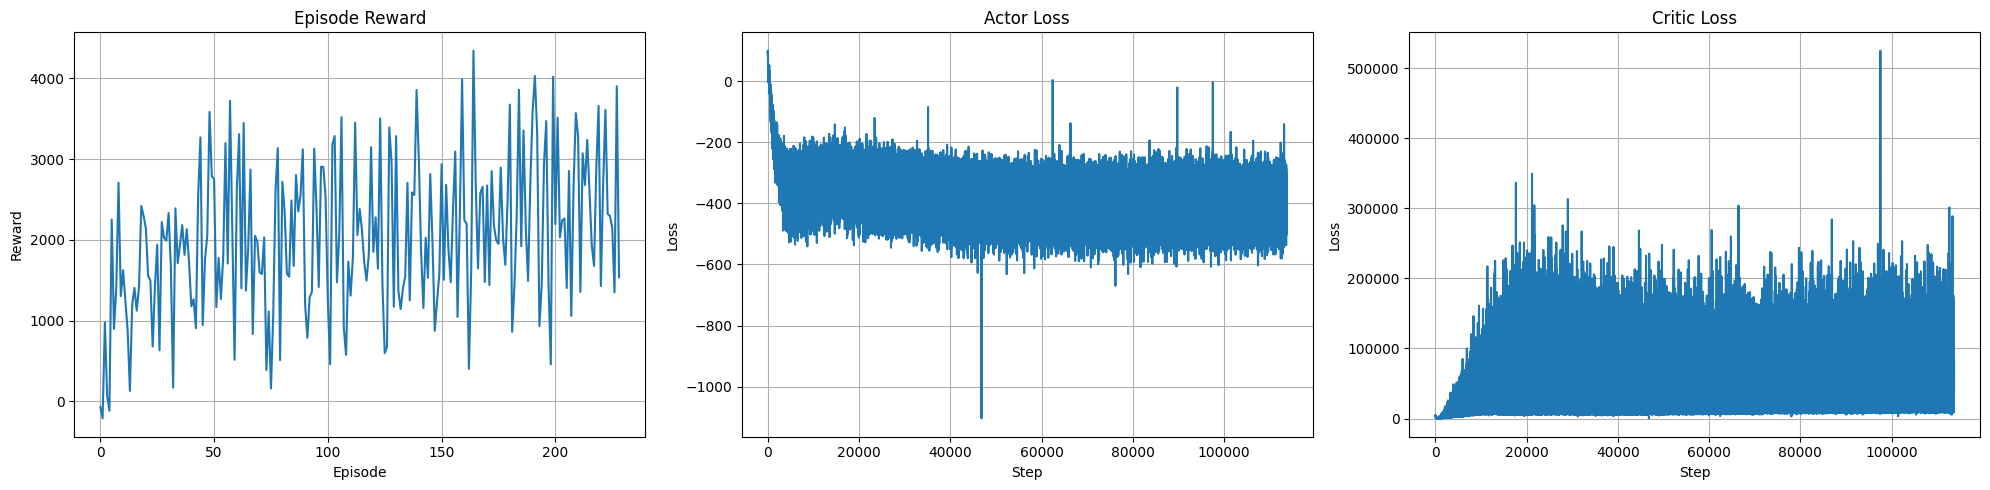

100%|██████████| 100000/100000 [39:30<00:00, 42.18it/s]


In [ ]:
actor_losses = []
critic_losses = []
episode_rewards = []

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_dim = 128
actor = Actor(state_dim, action_dim, hidden_dim).to(device)

critic1 = QCritic(state_dim, action_dim, hidden_dim).to(device)
target_critic1 = QCritic(state_dim, action_dim, hidden_dim).to(device)
target_critic1.load_state_dict(critic1.state_dict())

critic2 = QCritic(state_dim, action_dim, hidden_dim).to(device)
target_critic2 = QCritic(state_dim, action_dim, hidden_dim).to(device)
target_critic2.load_state_dict(critic2.state_dict())

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=3e-4)
critic1_optimizer = torch.optim.Adam(critic1.parameters(), lr=3e-4)
critic2_optimizer = torch.optim.Adam(critic2.parameters(), lr=3e-4)


iterations = 100000
gamma = 0.99
lagrange_multiplier = 1.0
eval_freq = 500
tau = 0.005
eps = 1e-6

low, high = torch.tensor(env.action_space.low, dtype=torch.float32), torch.tensor(env.action_space.high, dtype=torch.float32)

for step in trange(iterations):
    # Sample a batch from the dataset
    batch = replay_buffer.sample()
    state = batch["observation"].to(device)
    action = torch.clamp(batch["action"], low + eps, high - eps).to(device)
    reward = batch["next"]["reward"].to(device)
    next_state = batch["next"]["observation"].to(device)
    not_done = ~batch["next"]["done"].to(device)

    actor.to(device)
    # Critic update
    with torch.no_grad():
        next_action = #<YOUR_CODE>
        next_q_value = #<YOUR_CODE>
        target_q_value = #<YOUR_CODE>
    current_q_value1 = #<YOUR_CODE>
    current_q_value2 = #<YOUR_CODE>
    critic_loss = #<YOUR_CODE>

    critic1_optimizer.zero_grad(set_to_none=True)
    critic2_optimizer.zero_grad(set_to_none=True)
    critic_loss.backward()
    critic1_optimizer.step()
    critic2_optimizer.step()

    # Actor update
    with torch.no_grad():
        sampled_action = #<YOUR_CODE>
        q = #<YOUR_CODE>
        v = #<YOUR_CODE>
        advantage = #<YOUR_CODE>
        weights = torch.exp(torch.clamp(advantage / lagrange_multiplier, -3, 3))

    distribution = actor.get_distribution(state)
    log_prob = #<YOUR_CODE>
    actor_loss = #<YOUR_CODE>

    actor_optimizer.zero_grad(set_to_none=True)
    actor_loss.backward()
    actor_optimizer.step()

    actor_losses.append(actor_loss.cpu().item())
    critic_losses.append(critic_loss.cpu().item())

    for param, target_param in zip(critic1.parameters(), target_critic1.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    for param, target_param in zip(critic2.parameters(), target_critic2.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    if step % eval_freq == 0:
        episode_rewards.append(evaluate(env, actor.cpu(), n_games=5))

        # Plotting the results
        clear_output(wait=True)
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 3, 1)
        plt.plot(episode_rewards)
        plt.title('Episode Reward')
        plt.xlabel('Episode')
        plt.ylabel('Reward')

        plt.subplot(1, 3, 2)
        plt.plot(actor_losses)
        plt.title('Actor Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 3)
        plt.plot(critic_losses)
        plt.title('Critic Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.show()


In [15]:
from gymnasium.wrappers import RecordVideo

# let's hope this will work
# don't forget to pray
with RecordVideo(env=env, video_folder="./videos") as env_monitor:
    evaluate(env_monitor, actor.cpu())

In [18]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))